In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

#configure matplotlib
%matplotlib notebook

In [2]:
class expoArrivalProcess:
    
    #define the expo arrival processes init func
    def __init__(self, limitBatches, maxBatchNum, arrivalsPerBatch, expectedInterarrivalTime):
        
        self.limitBatches = limitBatches
        self.maxBatchNum = maxBatchNum
        self.arrivalsPerBatch = arrivalsPerBatch
        self.expectedInterarrivalTime = expectedInterarrivalTime
        self.numBatches = 0
        self.currentTime = 0
        self.nextArrivalTime = self.currentTime + self.randExpo(self.expectedInterarrivalTime)
    
    
    #define the random expo var func
    def randExpo(self, expectedValue):
    
        # Get lambda from the user input expted value.
        lambdaGiven = 1 / expectedValue

        # Generate a random number using the inverse transform method.
        expoNum = (-1 / lambdaGiven) * np.log(1 - np.random.uniform(0, 1, 1))

        #return the expo num
        return expoNum
    
    #define the set next arrival time func
    def setNextArrivalTime(self, myNow):
        
        #set the next arrival time
        self.nextArrivalTime = myNow + self.randExpo(self.expectedInterarrivalTime)
        
        #return nothing
        return
    
    #define the get ner arrivals func
    def getNewArrivals(self, myNow):
        
        #init the num arrivals local var and set it
        #equal to 0
        numArrivals = 0
        
        #check to see if the user is limiting batches
        if (self.limitBatches):
            
            #if the user is limiting batches, check to see
            #if this process has reached the batch limit
            if (self.numBatches <= self.maxBatchNum):
                
                #if the batch limit has not been reached,
                #see if it is time for a new arrival
                if (myNow >= self.nextArrivalTime):
                    
                    #set the num arrivals to the new arrivals 
                    #per batch var value
                    numArrivals = self.arrivalsPerBatch
                    
                    #set the next arrival time
                    self.setNextArrivalTime(myNow)
                    
                    #increase the number of batches var
                    self.numBatches += 1
                    
                else:
                    
                    #set new arrivals to 0 if it is not 
                    #time for an arrival
                    numArrivals = 0
                    
            else:
                
                #set new arrivals to 0 if the batch limit
                #has been reached
                numArrivals = 0
                
        else:
            
            #if there is no batch limit, see if it is time
            #for a new arrival
            if (myNow >= self.nextArrivalTime):
                
                #set the num arrivals to the new arrivals 
                #per batch var value
                numArrivals = self.arrivalsPerBatch
                
                #set the next arrival time
                self.setNextArrivalTime(myNow)
                 
                #increase the number of batches var
                self.numBatches += 1
                
            else:
                
                #set new arrivals to 0 
                #if it is not time for a new arrival
                numArrivals = 0
                
        #return the number of new arrivals     
        return numArrivals

In [7]:
class expoServers:
    
    #define the expo servers init func
    def __init__(self, numServers, expectedServiceTime):
        
        self.numServers = numServers
        self.expectedServiceTime = expectedServiceTime
        self.numBusyServers = 0
        self.numIdleServers = self.numServers
        self.allBusy = False
        self.allIdle = True
        self.totalObjectsServed = 0
        self.totalServiceTimes = 0
        self.avgServiceTime = 0
        
        self.servers = pd.DataFrame(columns = ['server ID', 'server idle', 'serving object ID', 'time service started', 'time when free', 'total objects served'])
        
        #loop through the num servers to create 
        #the server dataframe
        for i in range(self.numServers):
            
            #create a new server dictionary
            newServer = {'server ID' : i, 'server idle' : 1, 'serving object ID' : math.nan, 'time service started' : math.nan, 'time when free' : math.nan, 'total objects served' : 0}

            #append the new server to the server dataframe
            self.servers = self.servers.append(newServer, ignore_index = True)
            
    #define the rand expo var func       
    def randExpo(self, expectedValue):
    
        # Get lambda from the user input expted value.
        lambdaGiven = 1 / expectedValue

        # Generate a random number using the inverse transform method.
        expoNum = (-1 / lambdaGiven) * np.log(1 - np.random.uniform(0, 1, 1))

        #return the expo num
        return expoNum
    
    #define the get server func
    def getServer(self, serverIndex, objectID, serviceTime):
        
        nextTimeWhenFree = serviceTime + self.randExpo(self.expectedServiceTime)
        
        #set the server at the appropriate server index to 
        #values that indiicate it is working, including
        #setting the time when it will next be free
        self.servers.at[serverIndex, 'server idle'] = 0
        self.servers.at[serverIndex, 'serving object ID'] = objectID
        self.servers.at[serverIndex, 'time service started'] = serviceTime
        self.servers.at[serverIndex, 'time when free'] = nextTimeWhenFree
        
        #return nothing
        return
    
    #define the free server func
    def freeServer(self, serverIndex, serviceTime):
        
        #increment the total objects served var
        self.totalObjectsServed += 1
        
        #increase the total service times var appropriately
        self.totalServiceTimes += serviceTime - self.servers.at[serverIndex, 'time service started']
        
        #set the server at teh appropriate server index to
        #values that indicate it is idle, including incrementing
        #its personal total objects served value
        self.servers.at[serverIndex, 'server idle'] = 1
        self.servers.at[serverIndex, 'serving object ID'] = math.nan
        self.servers.at[serverIndex, 'time service started'] = math.nan
        self.servers.at[serverIndex, 'time when free'] = math.nan
        self.servers.at[serverIndex, 'total objects served'] += 1
        
        #return nothing
        return
    
    #define the free servers func
    def freeServers(self, serviceTime):
        
        #get the total servers to be free at this time instance
        serversToFree = self.servers[self.servers['time when free'] <= serviceTime]
        
        #get the index values of the servers to free
        serversToFreeIndex = serversToFree.index.values
        
        #get the num servers to free
        numServersSetFree = len(serversToFreeIndex)
        
        #loop through the servers to free and free them
        for i in range(len(serversToFreeIndex)):
            
            self.freeServer(serversToFreeIndex[i], serviceTime)
        
        #set the num idle servers var
        self.numIdleServers = self.servers['server idle'].sum()
        
        #set teh num busy servers var
        self.numBusyServers = len(self.servers) - self.servers['server idle'].sum()
        
        #set the all idle flag
        self.allIdle = (len(self.servers) == self.servers['server idle'].sum())
        
        #set the all busy flag
        self.allBusy = (0 == self.servers['server idle'].sum())
        
        #return the num servers set free
        return numServersSetFree
    
    #define the check servers func
    def checkServers(self, objectID, serviceTime):
        
        #loop through idle servers and put them to work
        if (1 in self.servers['server idle'].values):
            
            idleServerIndex = (self.servers['server idle'] == True).idxmax()
            
            self.getServer(idleServerIndex, objectID, serviceTime)
        
        #set servers free if it is their time to be free
        numServersSetFree = self.freeServers(serviceTime)
        
        if (self.totalObjectsServed > 0):
            
            self.avgServiceTime = self.totalServiceTimes / self.totalObjectsServed
        
        #return the number of servers set free
        return numServersSetFree

In [8]:
class Queue:
    
    #define the queue init func
    def __init__(self, queueID):
        
        self.queueID = queueID
        self.queue = pd.DataFrame(columns = ['arrival time', 'object ID'])
        self.numInQueue = 0
        self.totalNumInQueueOverTime = 0
        self.avgNumInQueue = 0
        self.lastArrivalTime = 0
        self.interarrivalTime = 0
        self.totalInterarrivalTimes = 0
        self.avgInterarrivalTime = 0
        self.totalObjectsThroughQueue = 0
        self.timeCounts = 0
    
    #define the add object func
    def addObject(self, arrivalTime):
        
            #increment the total objects through queue var
            self.totalObjectsThroughQueue += 1
            
            #increment the nume in queue var
            self.numInQueue += 1
            
            #get the interarrival time
            self.interarrivalTime = arrivalTime - self.lastArrivalTime
            
            #increase the total interarrival times var accordingly
            self.totalInterarrivalTimes += self.interarrivalTime
            
            #calcualte the average interarrival time
            self.avgInterarrivalTime = self.totalInterarrivalTimes / self.totalObjectsThroughQueue
        
            #create a new arrival dictionary
            newArrival = {'arrival time' : arrivalTime, 'object ID' : self.totalObjectsThroughQueue}

            #append the new arrival to the queue dataframe
            self.queue = self.queue.append(newArrival, ignore_index = True)
            
            #set the last arrival time var accordingly
            self.lastArrivalTime = arrivalTime
            
            #return nothing
            return
    
    #define the move object func
    def removeObject(self, serviceTime):
        
            #get the arrival time of the object to be removed
            arrivalTime = self.queue['arrival time'].iloc[0]
            
            #calcualte the time in queue for the object
            #to be removed
            delayTime = serviceTime - arrivalTime
    
            #decrment the num in queue var
            self.numInQueue -= 1
        
            #remove the top object from the queue 
            #(FCFS for now, could do more later)
            self.queue = self.queue.iloc[1:]
            
            #return the delay time
            return delayTime
        
    #define the calculate avg in queue func
    def calcAvgInQueue(self):
        
        self.timeCounts += 1
        self.totalNumInQueueOverTime += self.numInQueue
        self.avgNumInQueue = self.totalNumInQueueOverTime / self.timeCounts

In [9]:
def qMM1(expectedArrivalRate, expectedService, simTime):
    
    #set the sim time divider (allows for decimal places)
    simTimeDivider = 100
    
    #set the arrival process parameters
    limitBatches = False
    maxBatchNum = 0
    arrivalsPerBatch = 1 
    expectedInterarrivalTime = 1 / expectedArrivalRate * simTimeDivider
    
    #set the queue parameters
    queueID = 1
    
    #set the servers parameters
    numServers = 1
    expectedServiceTime = 1 / expectedService * simTimeDivider

    #init the arrival process
    arrivalProcess = expoArrivalProcess(limitBatches, maxBatchNum, arrivalsPerBatch, expectedInterarrivalTime)

    #init the queue
    queueMM1 = Queue(queueID)

    #init the servers
    myServers = expoServers(numServers, expectedServiceTime)
    
    #init appropriate queue stat dataframes
    numObjectsInQueue = pd.DataFrame(columns = ['num in queue'])
    objectDelays = pd.DataFrame(columns = ['object delay'])
    
    #set numServersFreed to 0
    numServersFreed = 0

    #loop through the sim time and run the sim
    #set simTime * the simTimeDivider, then use
    #the simTimeDivider to get decimal places throughout
    #the whole simulation
    for i in range(simTime * simTimeDivider):

        #get this instance of time
        myNow = i / simTimeDivider

        #get the num arrivals
        numArrivals = arrivalProcess.getNewArrivals(myNow)

        #check to see if num arrivals is greater than 0
        if (numArrivals > 0):

            #if num arrivals is greater than 0,
            #loop through th enum arrivals and
            #add them to the queue
            for j in range(numArrivals):

                queueMM1.addObject(myNow)

        #check to see if the queue length is greater than 0
        if (len(queueMM1.queue) > 0):

            #if the queue length is greater than 0, check the servers
            #and set the num servers freed var appropriately
            numServersFreed = myServers.checkServers(i, myNow)

        else:

            #if the queue length is less than or equal to 0
            #set the num servers freed var to 0
            numServersFreed = 0

        #check to see if the num servers freed is greater than 0
        if (numServersFreed > 0):

            #if the num servers freed is greater than 0,
            #loop through the num servers freed
            #and remove objects from the queue for each one
            #while calculating the object delay queue stat
            #and add it to the object delay dataframe
            for i in range(numServersFreed):

                objectDelay = queueMM1.removeObject(myNow)

                objectDelayDict = {'object delay' : objectDelay}
                objectDelays = objectDelays.append(objectDelayDict, ignore_index = True) 
        
        #calculate the av number of objects in the queue
        queueMM1.calcAvgInQueue()
        
        #check to see if this instant of time is an int
        #if so, print it so that the user can see the progress
        #on this function
        if (myNow.is_integer()):
            
            if(math.isclose((myNow % 1000), 0, rel_tol = 1e-5)):
            
                print(str(myNow) + "...", end = '')
            
            #calculate the num in queue stat and
            #add it to the num in queue dataframe
            numInQueueDict = {'num in queue' : queueMM1.numInQueue}
            numObjectsInQueue = numObjectsInQueue.append(numInQueueDict, ignore_index = True)
    
    #if the sim loop is over, print done
    print("Done!")
    
    #return the queue stats dataframes and sim objects
    return numObjectsInQueue, objectDelays, arrivalProcess, queueMM1, myServers

In [10]:
def getPredictedPn(arrivalRate, serviceRate, mySeries):
    
    #convert the series to a new dataframe
    myDF = mySeries.to_frame()
    
    #add predicted Pn column to the dataframe
    myDF['predicted Pn'] = 0.0
    
    #instantiate rho
    rho = float(arrivalRate) / float(serviceRate)

    #calculate the packets in queue at each packet arrival
    #instance in the model, and set that value to in 
    #appropriate position in the packets in queue column
    for i in range(0, len(mySeries)):
        
        #calculate the predicted Pn
        predictedPn = (1 - rho) * rho ** i

        #set the predicted Pn value in the predicted Pn
        #column of the dataframe
        myDF.at[i, 'predicted Pn'] = predictedPn
    
    #return the dataframe
    return myDF

In [11]:
#sim a MM1 queue with a sim time of 10000 steps
numObjectsInQueueMM1, objectDelaysMM1, arrivalProcessMM1, queueMM1, myServersMM1 = qMM1(5, 15, 100000)

0.0...1000.0...2000.0...3000.0...4000.0...5000.0...6000.0...7000.0...8000.0...9000.0...10000.0...11000.0...12000.0...13000.0...14000.0...15000.0...16000.0...17000.0...18000.0...19000.0...20000.0...21000.0...22000.0...23000.0...24000.0...25000.0...26000.0...27000.0...28000.0...29000.0...30000.0...31000.0...32000.0...33000.0...34000.0...35000.0...36000.0...37000.0...38000.0...39000.0...40000.0...41000.0...42000.0...43000.0...44000.0...45000.0...46000.0...47000.0...48000.0...49000.0...50000.0...51000.0...52000.0...53000.0...54000.0...55000.0...56000.0...57000.0...58000.0...59000.0...60000.0...61000.0...62000.0...63000.0...64000.0...65000.0...66000.0...67000.0...68000.0...69000.0...70000.0...71000.0...72000.0...73000.0...74000.0...75000.0...76000.0...77000.0...78000.0...79000.0...80000.0...81000.0...82000.0...83000.0...84000.0...85000.0...86000.0...87000.0...88000.0...89000.0...90000.0...91000.0...92000.0...93000.0...94000.0...95000.0...96000.0...97000.0...98000.0...99000.0...Done!


<IPython.core.display.Javascript object>


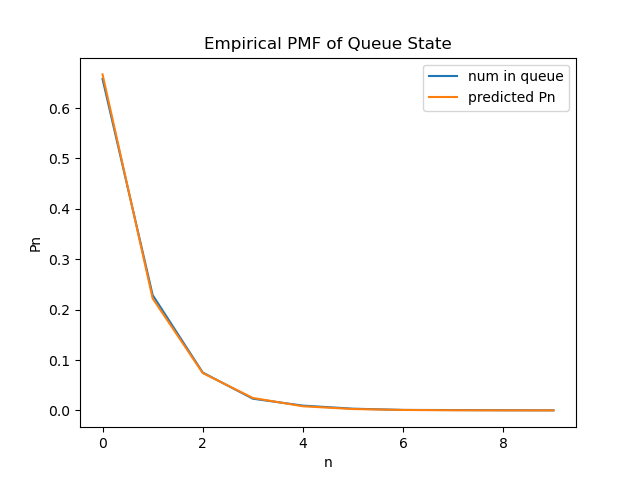

100000


In [15]:
#configure matplotlib
%matplotlib notebook

#remove some of the data regarding initial objects
#in the queue, since it wasn't near stead state then
numObjectsInQueueForGraph = numObjectsInQueueMM1.iloc[20000:]

#get the queue state and store it in a series
queueStateMM1 = numObjectsInQueueForGraph['num in queue'].value_counts().sort_index() / numObjectsInQueueForGraph.size

#get the predicted pn values and store them in 
#a dataframe with the queue state
queueStateMM1 = getPredictedPn(5, 15, queueStateMM1)

# Plot the PMF
ax = queueStateMM1.plot(kind = 'line')

# Set the graph title
plt.title('Empirical PMF of Queue State')

#set the axis labels
plt.xlabel("n")
plt.ylabel("Pn")

print(len(numObjectsInQueueMM1))

In [13]:
print("Expected number of packtes in MM1 system with rho = 0.8: " + str(numObjectsInQueueMM1['num in queue'].mean()))
print("Calculated number of packets in MM1 system with rho = 0.8: " + str(5 / (15 - 5)))
print("Expected delay of packets in MM1 system with rho = 0.8: " + str(objectDelaysMM1['object delay'].mean() / 100))
print("Calculated delay of packets in MM1 system with rho = 0.8: " + str(1 / (15 - 5)))
print("Avg. interarrival time: " + str(queueMM1.avgInterarrivalTime / 100))
print(queueMM1.totalObjectsThroughQueue)

Expected number of packtes in MM1 system with rho = 0.8: 0.52474
Calculated number of packets in MM1 system with rho = 0.8: 0.5
Expected delay of packets in MM1 system with rho = 0.8: 0.10433590610702195
Calculated delay of packets in MM1 system with rho = 0.8: 0.1
Avg. interarrival time: 0.19883362497514415
5029
